<a href="https://colab.research.google.com/github/joseduardogon/AlzheimerDetection/blob/main/CNN_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Introdução***

---




> No Brasil, segundo dados de 2021, 1,2 milhão de pessoas vivem com alguma forma de demência e em torno de 100 mil novos casos são diagnosticados por ano. No mundo, cerca de 50 milhões de pessoas vivem com a doença e, segundo estimativas da Alzheimer's Disease International(ADI), até 2050 o número de pessoas afetadas deve triplicar.

>Diante desse panorama, é notável a importância de um diagnóstico antecipado e formas eficientes de identificar precisamente a doença, com finalidade de retardar o avanço e estimular medidas preventivas para as pessoas acometidas.

>Nesse contexo, este projeto tem como objetivo desenvolver uma CNN(rede neural convolucional) que, através de imagens de ressonância magnética do cérebro de pacientes, seja capaz de identificar a presença de demência e a classificar em 4 grupos distintos, sendo eles:


*   Sem demência
*   Demência muito leve
*   Demência leve
*   Demência moderada

>Se bem sucedida, a rede neural seria capaz de auxiliar o trabalho de inúmeros médicos e contribuir para uma "linha de produção" mais eficiente dentro dos hospitais, em especial os que fazem parte da rede pública.

# ***Formulação do problema e objetivos***

>Para o desenvolvimento dessa rede neural, foi utilizado um banco dados com 6400 imagens de ressonância magnética do cérebro de diferentes pacientes(Disponível em https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset). O banco de dados é composto por imagens de formato .jpg com resolução de 128 x 128 pixels. Dessas 6400 amostras, 3200 pertencem a classe de pessoas sem demência, 2240 a classe de demência muito leve, 896 a classe de demência leve e 64 a classe de demência moderada.

>Como apontado previamente, o objetivo da rede neureal é, através de uma imagem de ressonância magnética, conseguir determinar precisamente o grau de demência, caso ele exista, de um paciente. A arquitetura convolucional foi escolhida devido a sua melhor perfomance para treinamento de modelos que envolvem processamento de imagens.




# ***Metodologia e desenvolvimento do código da CNN***

In [2]:
#importando bibliotecas

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

In [3]:
#fazendo download do dataset do kaggle

! pip install -q kaggle

from google.colab import files
files.upload()

#upload do arquivo kaggle.json que pode ser baixado através da sua conta kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
#fazendo download do dataset
! kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

 93% 26.0M/28.0M [00:02<00:00, 20.2MB/s]
100% 28.0M/28.0M [00:02<00:00, 12.2MB/s]


In [5]:
#descomprimindo o dataset
import zipfile
zip_ref = zipfile.ZipFile('alzheimer-mri-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

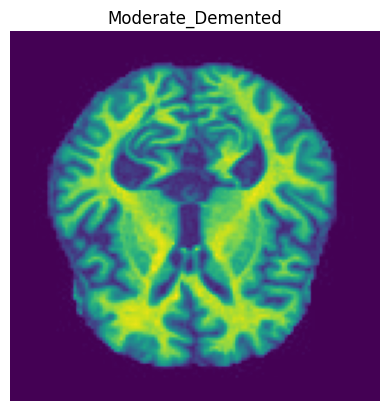

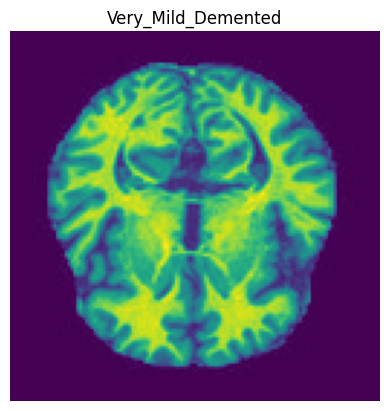

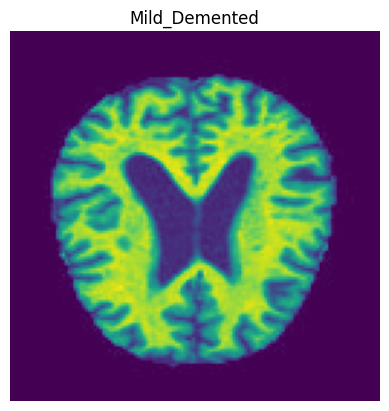

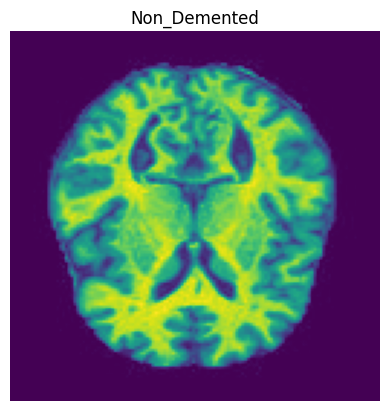

In [6]:
#exibindo um exemlpo de imagem para cada uma das 4 classes
import os
from PIL import Image

base_path = "/content/Dataset"
classes = os.listdir(base_path)

# Exibir uma imagem pra cada classe
for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

    # Exibe a primeira imagem pra cada classe
    if len(image_files) > 0:
        image_path = os.path.join(class_path, image_files[0])
        image = Image.open(image_path)

        plt.imshow(image)
        plt.title(class_name)
        plt.axis('off')
        plt.show()

#***Divisão dos dados***
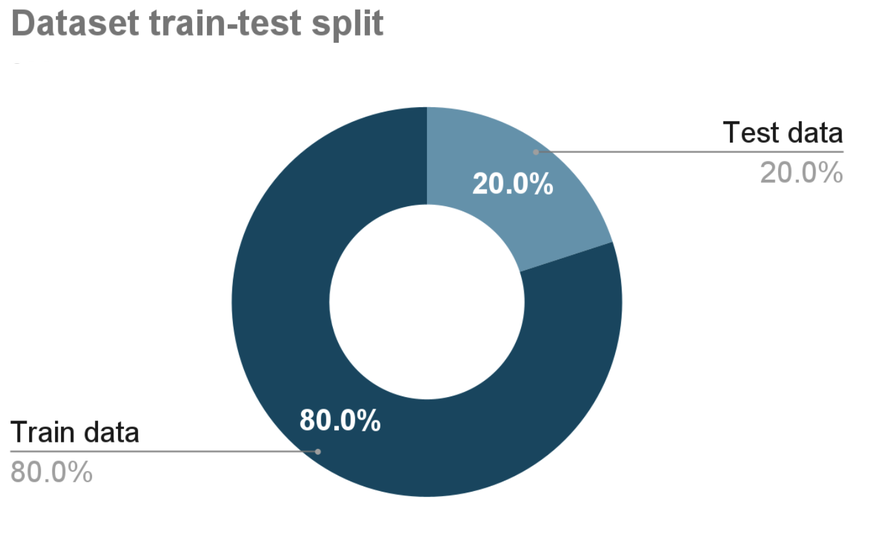

In [7]:
#Carregando e dividindo o dataset em Treino e Teste

data = r'/content/Dataset'
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    labels = 'inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=0,
    color_mode='grayscale',
    image_size=(128,128),
    batch_size=40,
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    labels = 'inferred',
    label_mode='categorical',
    validation_split= 0.2,
    subset="validation",
    seed=0,
    color_mode= 'grayscale',
    image_size = (128,128),
    batch_size=40,
)

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.


# ***Criando e treinando a CNN***

In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

# Load EfficientNetB0 model without top (classification) layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Modify the first convolutional layer for smaller input size
base_model.layers[0].kernel_size = (3, 3)
base_model.layers[0].strides = (1, 1)

# Add your custom top layers for your specific task
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)

# Create the modified model
model = Model(inputs=base_model.input, outputs=output)


16705208/16705208 [==============================] - 2s 0us/step


In [10]:
# Compile the model and train it on your data
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 batch_normalization (Batch  (None, 20480)             81920     
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 256)               5243136   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1

In [11]:
history = model.fit(x= train_data, epochs= 50, verbose= 0,
                    validation_data= test_data, validation_steps= None, shuffle= False)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 4, 4, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 batch_normalization (Batch  (None, 20480)             81920     
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 256)               5243136   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1

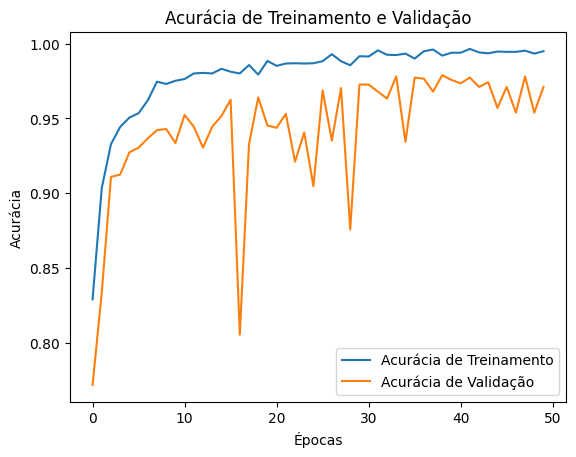

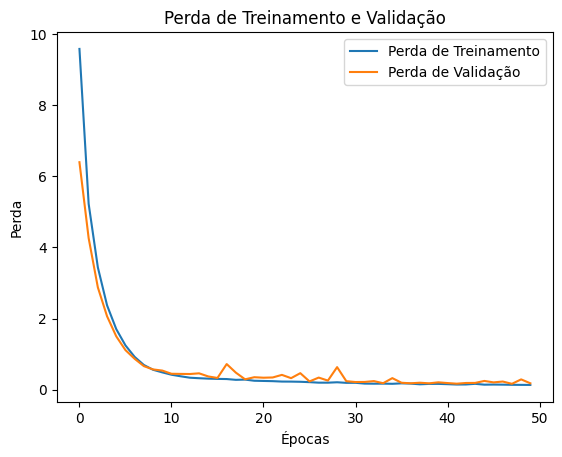

In [13]:
import matplotlib.pyplot as plt

#Plotar a acurácia de treinamento e validação por época
plt.figure()
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

#Plotar a perda de treinamento e validação por época
plt.figure()
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda de Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()


2/2 [==============================] - 0s 28ms/step


Text(95.72222222222221, 0.5, 'Verdadeiro')

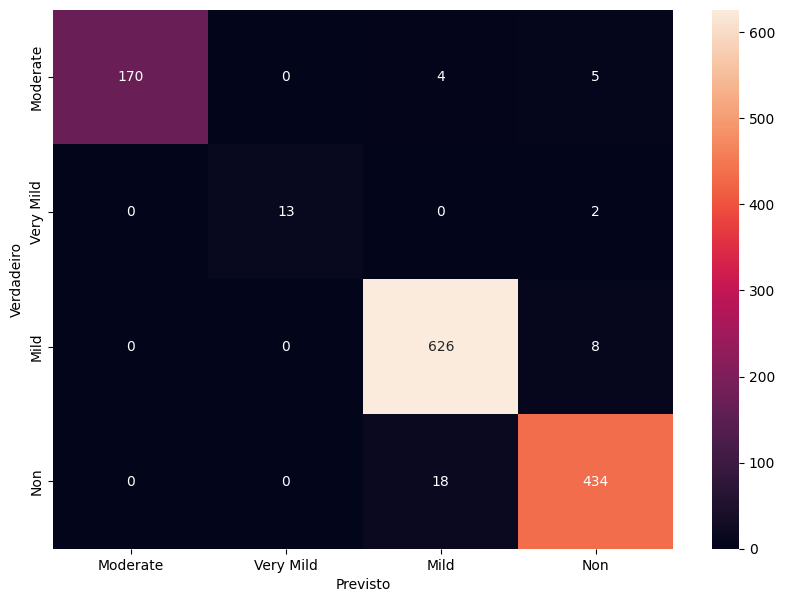

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Inicializar listas vazias para armazenar os rótulos verdadeiros e previstos
y_test_classes = []
y_pred_classes = []

# Iterar sobre os dados de teste
for images, labels in test_data:
    # Adicionar os rótulos verdadeiros à lista y_test_classes
    y_test_classes.extend(np.argmax(labels.numpy(), axis=1))

    # Usar o modelo para fazer previsões
    y_pred = model.predict(images)

    # Adicionar as previsões à lista y_pred_classes
    y_pred_classes.extend(np.argmax(y_pred, axis=1))

# Calcular a matriz de confusão
cm = confusion_matrix(y_test_classes, y_pred_classes)

import pandas as pd

# Definir os rótulos das classes
class_labels = ['Moderate', 'Very Mild', 'Mild', 'Non']

# Criar um DataFrame para a matriz de confusão com rótulos de classe
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')



In [28]:
from sklearn.metrics import classification_report

# Use o modelo para fazer previsões nos dados de teste
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Iterar sobre os dados de teste para obter os rótulos verdadeiros
y_test_classes = []
for images, labels in test_data:
    y_test_classes.extend(np.argmax(labels.numpy(), axis=1))

# Calcular a perda e a acurácia usando a função evaluate()
loss, accuracy = model.evaluate(test_data)

# Calcular a precisão, o recall e o F1-score
report = classification_report(y_test_classes, y_pred_classes, target_names=class_labels)

print('Perda:', loss)
print('Acurácia:', accuracy)
print('Relatório de Classificação:\n', report)



32/32 [==============================] - 1s 28ms/step - loss: 0.1793 - accuracy: 0.9711
Perda: 0.1793452799320221
Acurácia: 0.9710937738418579
Relatório de Classificação:
               precision    recall  f1-score   support

    Moderate       0.14      0.13      0.13       179
   Very Mild       0.00      0.00      0.00        15
        Mild       0.47      0.48      0.47       634
         Non       0.33      0.33      0.33       452

    accuracy                           0.37      1280
   macro avg       0.23      0.23      0.23      1280
weighted avg       0.37      0.37      0.37      1280



2/2 [==============================] - 0s 31ms/step


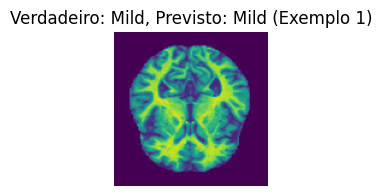

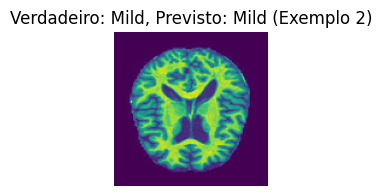

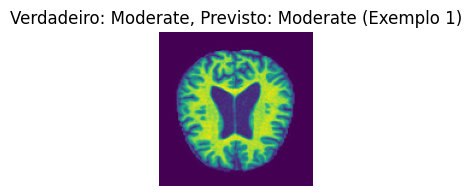

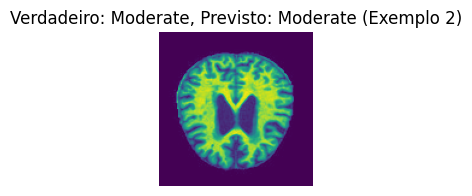

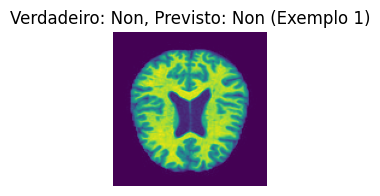

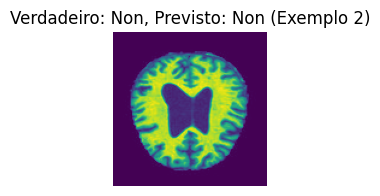

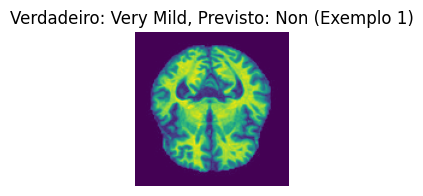

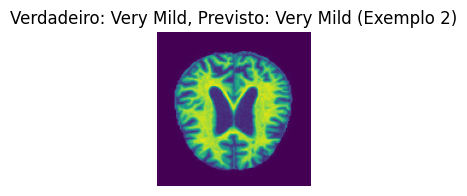

In [33]:
# Inicializar um dicionário para armazenar dois exemplos de cada classe
examples = {}

# Iterar sobre os dados de teste
for images, labels in test_data:
    # Use o modelo para fazer previsões
    predictions = model.predict(images)

    # Obter os rótulos de classe previstos e verdadeiros
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    # Adicionar dois exemplos de cada classe ao dicionário
    for i in range(len(true_classes)):
        if true_classes[i] not in examples:
            examples[true_classes[i]] = [(images[i], predicted_classes[i])]
        elif len(examples[true_classes[i]]) < 2:
            examples[true_classes[i]].append((images[i], predicted_classes[i]))

    # Parar quando tivermos dois exemplos de cada classe
    if all(len(examples[i]) == 2 for i in range(4)):
        break

# Plotar dois exemplos de cada classe
for true_class, example_list in examples.items():
    for i, (image, predicted_class) in enumerate(example_list):
        plt.figure(figsize=(2, 2))
        plt.imshow(image.numpy().astype('uint8'))
        plt.title(f"Verdadeiro: {class_labels[true_class]}, Previsto: {class_labels[predicted_class]} (Exemplo {i+1})")
        plt.axis('off')


